# Blind Quantum Computing

Este notebook executa o código de Blind Quantum Computing utilizando Qiskit. O objetivo é demonstrar como rodar experimentos quânticos de forma segura e privada, utilizando um dataset de exemplo (Iris).

In [26]:
# Instalar dependências
!pip install matplotlib
!pip install qiskit qiskit-machine-learning scikit-learn torch

In [27]:
# instalar as bibliotecas necessárias
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Sampler # Primitiva V2
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
import torch.nn as nn
import numpy as np
import collections
from quantumnet.components import Network, Logger

# Controle de Aleatoriedade e Reprodutibilidade
O trecho abaixo define uma semente fixa (SEED = 42) e a aplica nas bibliotecas random, numpy e torch. Isso garante que os resultados aleatórios (como inicialização de pesos e embaralhamento de dados) sejam os mesmos a cada execução do código, o que é essencial para fins de reprodutibilidade. 

Além disso, o uso de torch.use_deterministic_algorithms(True) força o PyTorch a utilizar apenas algoritmos determinísticos, evitando variações internas e tornando os experimentos mais consistentes e confiáveis.

In [28]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.use_deterministic_algorithms(True)

# Inicializar a rede

2025-08-13 14:39:48,053: Host 0 inicializado com 0 qubits.
2025-08-13 14:39:48,055: Host 1 inicializado com 0 qubits.
2025-08-13 14:39:48,056: Host 2 inicializado com 0 qubits.
2025-08-13 14:39:48,056: Host 3 inicializado com 0 qubits.
2025-08-13 14:39:48,057: Host 4 inicializado com 0 qubits.
2025-08-13 14:39:48,058: Host 5 inicializado com 0 qubits.
2025-08-13 14:39:48,059: Host 6 inicializado com 0 qubits.
2025-08-13 14:39:48,059: Host 7 inicializado com 0 qubits.
2025-08-13 14:39:48,059: Host 8 inicializado com 0 qubits.
2025-08-13 14:39:48,060: Par EPR <quantumnet.objects.epr.Epr object at 0x7ff7f88bfa30> adicionado ao canal.
2025-08-13 14:39:48,060: Par EPR <quantumnet.objects.epr.Epr object at 0x7ff80338bac0> adicionado ao canal.
2025-08-13 14:39:48,061: Par EPR <quantumnet.objects.epr.Epr object at 0x7ff803244040> adicionado ao canal.
2025-08-13 14:39:48,062: Par EPR <quantumnet.objects.epr.Epr object at 0x7ff7f90dbf40> adicionado ao canal.
2025-08-13 14:39:48,062: Par EPR <qua

Hosts inicializados
Canais inicializados
Pares EPRs adicionados


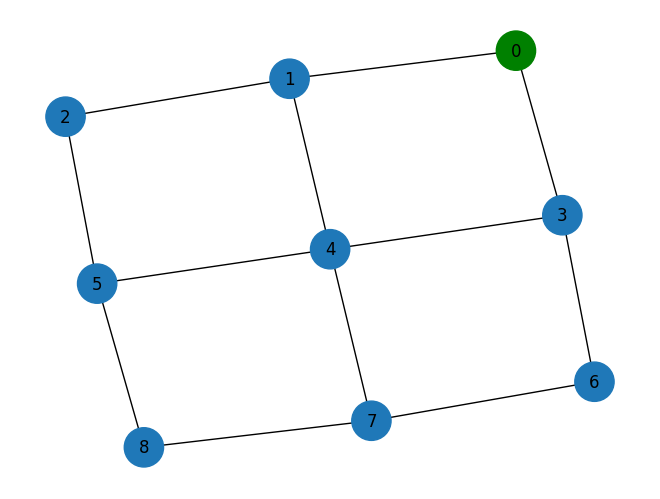

In [29]:
rede = Network()
rede.set_ready_topology('grade',8,3,3) 
rede.draw()
Logger.activate(Logger)

# Carrega o conjunto de dados Iris
- X → dados (características/features) 
- y → rótulos (classes/labels)

In [30]:
iris = load_iris()
X = iris.data 
y = iris.target

# Divide os dados 
80% treino e 20% teste

- test_size -> define que 20% dos dados serão usados para teste (logo, 80% vão para treino)
- random_state -> os dados são embaralhados aleatoriamente antes de dividir em treino e teste.
- stratify -> mantém a mesma proporção de cada classe nos conjuntos de treino e teste (boa prática em classificações)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Distribuição das classes no y_train e y_test:")
print("Treino:", collections.Counter(y_train))
print("Teste:", collections.Counter(y_test))

Distribuição das classes no y_train e y_test:
Treino: Counter({np.int64(0): 40, np.int64(2): 40, np.int64(1): 40})
Teste: Counter({np.int64(0): 10, np.int64(2): 10, np.int64(1): 10})


# Normaliza os dados
- Normalizar = colocar tudo na mesma escala (de 0 a 1).
- Isso ajuda o modelo a aprender melhor e evita que uma variável "grite" mais que as outras.
- ex: Se uma variável vai de 0 a 1000 e outra vai de 0 a 1, a maior domina o aprendizado

In [32]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define número de qubits
- Se o conjunto de dados tem 4 features (ex: comprimento da pétala, largura da pétala etc),
- então são necessários 4 qubits para representar e processar cada uma dessas features no circuito quântico.

In [33]:
num_qubits = X_train.shape[1]

# Feature map e ansatz
- Feature Map → insere as features no circuito quântico
- RealAmplitudes → um tipo específico de ansatz do Qiskit, onde ele monta um circuito que trabalha com rotações e entrelaçamento. Isso faz com que ele consiga representar padrões/pesos diferentes nas features. "onde tem peso para aprender"

- Quantos mais os números de reps crescer mais a chance de overfitting (treinar de uma forma errada)

In [34]:
feature_map = ZZFeatureMap(feature_dimension=num_qubits)
ansatz = RealAmplitudes(num_qubits, reps=2)

# Cria o circuito
- etapa que cria um circuito quântico vazio, transforma os dados clássicos (números normais) em um estado quântico e ) e depois coloca o ansatz para o modelo conseguir aprender os padrões/pesos das features.


In [35]:
qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# SamplerQNN
- Ele usa o Sampler para fazer o trabalho quântico, mas adiciona toda a lógica necessaria para que o processo se pareça e se comporte como uma camada de uma rede neural.

- E permite treinar ela usando PyTorch, igual uma rede neural clássica.

In [36]:
sampler = Sampler()
qnn = SamplerQNN(
    sampler=sampler, 
    circuit=qc,
    input_params=feature_map.parameters,  # Informa à QNN quais são os parâmetros de entrada
    weight_params=ansatz.parameters      # Informa à QNN quais são os pesos treináveis
)


model = nn.Sequential(
    TorchConnector(qnn),
    nn.Linear(qnn.output_shape[0], num_qubits)
)

/tmp/ipykernel_27252/504677551.py:1: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/tmp/ipykernel_27252/504677551.py:2: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


# Otimização com PyTorch
- X_train_tensor e y_train_tensor → Convertem os dados de treino (X_train e y_train) de NumPy pra tensor do PyTorch, que é o formato que o modelo entende.

- optimizer = torch.optim.Adam(...) → Define o otimizador Adam, que ajusta os pesos do modelo pra minimizar o erro.

- lr=0.1 → Taxa de aprendizado (velocidade que ele ajusta os pesos com base nos erros, não pode ser muito alto e não muito baixo).

- loss_func = torch.nn.CrossEntropyLoss() → Esta é a função de perda padrão e mais recomendada para problemas de classificação multiclasse (quando você tem 3 ou mais classes possíveis, como no caso do dataset Iris).

In [37]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_func = torch.nn.CrossEntropyLoss()

# Treinamento
- model.train() → Coloca o modelo no modo treino
- optimizer.zero_grad() → Zera os gradientes dos cálculos anteriores pra não acumular.
- outputs = model(X_train_tensor) →  usa os dados de treino no modelo para fazer uma previsão/estimativa.
- loss → calcula o erro
- loss.backward() → Calcula os gradientes, ou seja, descobre pra onde e quanto cada peso deve mudar pra reduzir o erro.
- optimizer.step() → usa esses gradientes pra mudar os pesos do ansatz. Ele faz isso pra tentar diminuir o erro na próxima vez que roda

In [38]:
# --- 6. Loop de Treinamento com Simulação BQC ---
print("\nIniciando o treinamento...")
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    
    loss = loss_func(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    print(f"Época {epoch+1}/{num_epochs}, Perda (Loss): {loss.item():.4f}")

    # --- INÍCIO DA INTEGRAÇÃO DA REDE QUÂNTICA ---
    trained_weights = model[0].weight.detach().numpy()
    
    final_circuit = QuantumCircuit(num_qubits)
    final_circuit.compose(feature_map, inplace=True)
    final_circuit.compose(ansatz.assign_parameters(trained_weights), inplace=True)
    
    circuit_depth = final_circuit.depth()
    
    print(f"Executando simulação BQC para a época {epoch+1} com profundidade de circuito: {circuit_depth}")
    rede.application_layer.run_app(
        "AC_BQC",
        alice_id=6,
        bob_id=0,
        num_qubits=num_qubits,
        scenario=2,
        circuit_depth=circuit_depth
    )

    rede.start_eprs()
    # --- FIM DA INTEGRAÇÃO DA REDE QUÂNTICA ---


Iniciando o treinamento...


2025-08-13 14:40:25,510: Timeslot 0: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-08-13 14:40:25,511: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-08-13 14:40:25,511: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-08-13 14:40:25,513: Cliente criou 4 qubits para a transmissão.
2025-08-13 14:40:25,513: Qubit 624 registrado no timeslot 0
2025-08-13 14:40:25,513: Qubit 792 registrado no timeslot 0
2025-08-13 14:40:25,514: Qubit 295 registrado no timeslot 0
2025-08-13 14:40:25,515: Qubit 941 registrado no timeslot 0
2025-08-13 14:40:25,515: Qubit 624 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:25,515: Qubit 792 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:25,516: Qubit 295 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:25,516: Qubit 941 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:25,517: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-08-13 14:40:25,517: Instruç

Época 1/10, Perda (Loss): 1.4349
Executando simulação BQC para a época 1 com profundidade de circuito: 2
Tempo de Operação: 2
Pares EPRs adicionados


2025-08-13 14:40:32,560: Timeslot 11: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-08-13 14:40:32,561: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-08-13 14:40:32,563: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-08-13 14:40:32,564: Cliente criou 4 qubits para a transmissão.
2025-08-13 14:40:32,566: Qubit 367 registrado no timeslot 11
2025-08-13 14:40:32,567: Qubit 334 registrado no timeslot 11
2025-08-13 14:40:32,569: Qubit 919 registrado no timeslot 11
2025-08-13 14:40:32,570: Qubit 968 registrado no timeslot 11
2025-08-13 14:40:32,571: Qubit 367 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:32,572: Qubit 334 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:32,574: Qubit 919 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:32,575: Qubit 968 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:32,576: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-08-13 14:40:32,578: In

Época 2/10, Perda (Loss): 1.3299
Executando simulação BQC para a época 2 com profundidade de circuito: 2
Tempo de Operação: 2
Pares EPRs adicionados


2025-08-13 14:40:39,776: Timeslot 22: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-08-13 14:40:39,777: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-08-13 14:40:39,778: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-08-13 14:40:39,779: Cliente criou 4 qubits para a transmissão.
2025-08-13 14:40:39,780: Qubit 264 registrado no timeslot 22
2025-08-13 14:40:39,780: Qubit 308 registrado no timeslot 22
2025-08-13 14:40:39,780: Qubit 561 registrado no timeslot 22
2025-08-13 14:40:39,781: Qubit 489 registrado no timeslot 22
2025-08-13 14:40:39,781: Qubit 264 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:39,783: Qubit 308 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:39,783: Qubit 561 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:39,784: Qubit 489 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:39,784: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-08-13 14:40:39,785: In

Época 3/10, Perda (Loss): 1.2507
Executando simulação BQC para a época 3 com profundidade de circuito: 2
Tempo de Operação: 2
Pares EPRs adicionados


2025-08-13 14:40:46,798: Timeslot 33: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-08-13 14:40:46,799: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-08-13 14:40:46,800: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-08-13 14:40:46,801: Cliente criou 4 qubits para a transmissão.
2025-08-13 14:40:46,802: Qubit 982 registrado no timeslot 33
2025-08-13 14:40:46,802: Qubit 499 registrado no timeslot 33
2025-08-13 14:40:46,803: Qubit 259 registrado no timeslot 33
2025-08-13 14:40:46,803: Qubit 105 registrado no timeslot 33
2025-08-13 14:40:46,804: Qubit 982 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:46,804: Qubit 499 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:46,804: Qubit 259 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:46,805: Qubit 105 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:46,805: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-08-13 14:40:46,805: In

Época 4/10, Perda (Loss): 1.1910
Executando simulação BQC para a época 4 com profundidade de circuito: 2
Tempo de Operação: 2
Pares EPRs adicionados


2025-08-13 14:40:53,803: Timeslot 44: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-08-13 14:40:53,804: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-08-13 14:40:53,805: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-08-13 14:40:53,806: Cliente criou 4 qubits para a transmissão.
2025-08-13 14:40:53,806: Qubit 179 registrado no timeslot 44
2025-08-13 14:40:53,807: Qubit 753 registrado no timeslot 44
2025-08-13 14:40:53,808: Qubit 815 registrado no timeslot 44
2025-08-13 14:40:53,808: Qubit 491 registrado no timeslot 44
2025-08-13 14:40:53,809: Qubit 179 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:53,809: Qubit 753 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:53,810: Qubit 815 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:53,810: Qubit 491 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:40:53,810: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-08-13 14:40:53,811: In

Época 5/10, Perda (Loss): 1.1429
Executando simulação BQC para a época 5 com profundidade de circuito: 2
Tempo de Operação: 2
Pares EPRs adicionados


2025-08-13 14:41:01,051: Timeslot 55: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-08-13 14:41:01,052: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-08-13 14:41:01,052: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-08-13 14:41:01,053: Cliente criou 4 qubits para a transmissão.
2025-08-13 14:41:01,053: Qubit 454 registrado no timeslot 55
2025-08-13 14:41:01,053: Qubit 757 registrado no timeslot 55
2025-08-13 14:41:01,054: Qubit 45 registrado no timeslot 55
2025-08-13 14:41:01,054: Qubit 143 registrado no timeslot 55
2025-08-13 14:41:01,055: Qubit 454 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:01,056: Qubit 757 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:01,056: Qubit 45 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:01,057: Qubit 143 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:01,057: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-08-13 14:41:01,058: Inst

Época 6/10, Perda (Loss): 1.1013
Executando simulação BQC para a época 6 com profundidade de circuito: 2
Tempo de Operação: 2
Pares EPRs adicionados


2025-08-13 14:41:08,003: Timeslot 66: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-08-13 14:41:08,004: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-08-13 14:41:08,004: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-08-13 14:41:08,005: Cliente criou 4 qubits para a transmissão.
2025-08-13 14:41:08,006: Qubit 514 registrado no timeslot 66
2025-08-13 14:41:08,007: Qubit 113 registrado no timeslot 66
2025-08-13 14:41:08,007: Qubit 784 registrado no timeslot 66
2025-08-13 14:41:08,008: Qubit 595 registrado no timeslot 66
2025-08-13 14:41:08,008: Qubit 514 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:08,009: Qubit 113 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:08,010: Qubit 784 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:08,010: Qubit 595 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:08,010: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-08-13 14:41:08,011: In

Época 7/10, Perda (Loss): 1.0636
Executando simulação BQC para a época 7 com profundidade de circuito: 2
Tempo de Operação: 2
Pares EPRs adicionados


2025-08-13 14:41:14,935: Timeslot 77: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-08-13 14:41:14,936: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-08-13 14:41:14,936: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-08-13 14:41:14,937: Cliente criou 4 qubits para a transmissão.
2025-08-13 14:41:14,938: Qubit 97 registrado no timeslot 77
2025-08-13 14:41:14,939: Qubit 243 registrado no timeslot 77
2025-08-13 14:41:14,939: Qubit 12 registrado no timeslot 77
2025-08-13 14:41:14,940: Qubit 527 registrado no timeslot 77
2025-08-13 14:41:14,940: Qubit 97 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:14,940: Qubit 243 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:14,941: Qubit 12 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:14,941: Qubit 527 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:14,941: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-08-13 14:41:14,942: Instru

Época 8/10, Perda (Loss): 1.0283
Executando simulação BQC para a época 8 com profundidade de circuito: 2
Tempo de Operação: 2
Pares EPRs adicionados


2025-08-13 14:41:22,217: Timeslot 88: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-08-13 14:41:22,218: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-08-13 14:41:22,218: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-08-13 14:41:22,218: Cliente criou 4 qubits para a transmissão.
2025-08-13 14:41:22,218: Qubit 265 registrado no timeslot 88
2025-08-13 14:41:22,219: Qubit 378 registrado no timeslot 88
2025-08-13 14:41:22,219: Qubit 483 registrado no timeslot 88
2025-08-13 14:41:22,219: Qubit 235 registrado no timeslot 88
2025-08-13 14:41:22,219: Qubit 265 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:22,220: Qubit 378 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:22,220: Qubit 483 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:22,220: Qubit 235 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:22,222: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-08-13 14:41:22,223: In

Época 9/10, Perda (Loss): 0.9961
Executando simulação BQC para a época 9 com profundidade de circuito: 2
Tempo de Operação: 2
Pares EPRs adicionados


2025-08-13 14:41:29,207: Timeslot 99: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-08-13 14:41:29,208: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-08-13 14:41:29,209: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-08-13 14:41:29,209: Cliente criou 4 qubits para a transmissão.
2025-08-13 14:41:29,209: Qubit 408 registrado no timeslot 99
2025-08-13 14:41:29,210: Qubit 631 registrado no timeslot 99
2025-08-13 14:41:29,210: Qubit 548 registrado no timeslot 99
2025-08-13 14:41:29,211: Qubit 459 registrado no timeslot 99
2025-08-13 14:41:29,211: Qubit 408 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:29,212: Qubit 631 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:29,212: Qubit 548 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:29,214: Qubit 459 criado pelo Cliente - Estado: 0, Fase: 1
2025-08-13 14:41:29,215: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-08-13 14:41:29,215: In

Época 10/10, Perda (Loss): 0.9680
Executando simulação BQC para a época 10 com profundidade de circuito: 2
Tempo de Operação: 2
Pares EPRs adicionados


# Avaliação
- Primeiro ele, Faz previsão no conjunto de teste, sem atualizar o modelo.
- Transforma saída em probabilidade e decide se é classe 0 ou 1.
- Prepara os resultados para análise (cálculo das métricas).
# Métricas
- Acurácia: porcentagem de previsões corretas (tanto verdadeiros positivos quanto verdadeiros negativos).

- Precisão: proporção de previsões positivas que estavam corretas (foca em evitar falsos positivos).

- Recall: proporção de casos positivos corretamente identificados (foca em evitar falsos negativos).

In [39]:
# --- 7. Avaliação do Modelo ---
print("\nIniciando a avaliação final...")
model.eval()

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    outputs = model(X_test_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    y_pred = torch.argmax(probabilities, dim=1).numpy()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n--- MÉTRICAS DE AVALIAÇÃO (MULTICLASSE com V2) ---")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão (Macro): {precision:.2f}")
print(f"Recall (Macro): {recall:.2f}")
print(f"F1-Score (Macro): {f1:.2f}")




Iniciando a avaliação final...

--- MÉTRICAS DE AVALIAÇÃO (MULTICLASSE com V2) ---
Acurácia: 0.80
Precisão (Macro): 0.88
Recall (Macro): 0.80
F1-Score (Macro): 0.81


## Conclusões e próximos passos

- O experimento de Blind Quantum Computing foi executado com sucesso.
- Próximos passos podem incluir: testar outros datasets, aprimorar o circuito quântico, ou analisar a segurança do protocolo.